In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Benchmarking methods for identification of SVG

## Introduction

In this example, we will demonstrate how to use scDesign3Py to generate negative control and benchmark methods for identifying spatially variable genes (SVG) from spatial transcriptomics data. Please note that here we only did a very brief benchmarking for illustration purpose, not for formal comparison.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import scDesign3Py

import SpatialDE

The R project used is located at /home/ld/mambaforge/envs/cell2loc/lib/R


### Read in data

The raw data is from the [Seurat](https://satijalab.org/seurat/articles/spatial_vignette.html), which is a dataset generated with the Visium technology from 10x Genomics and converted to `.h5ad` file using the R package `sceasy`. We pre-select the top spatial variable genes.

To save time, we subset the top 200 genes.. 

In [3]:
data = ad.read_h5ad("data/VISIUM.h5ad")
data = data[:,0:200]
data

View of AnnData object with n_obs × n_vars = 2696 × 200
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'spatial1', 'spatial2', 'cell_type'
    var: 'name'

## Simulation

We use the step-by-step functions instead of the one-shot function to generate synthetic data since these step-by-step functions allow us to alter estimated parameters and generate new data based on our desired parameters.

In [4]:
example = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")

In [5]:
example_data = example.construct_data(    
    anndata = data,
    default_assay_name = "counts",
    celltype = "cell_type",
    spatial=["spatial1", "spatial2"],
    corr_formula = "1")

In [6]:
example.set_r_random_seed(123)
example_marginal = example.fit_marginal(
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k= 50)",
    sigma_formula = "1",
    family_use = "nb",
    usebam = False
)

  |                                                              |   0%, ETA NA

  |=======================================================| 100%, Elapsed 05:16


In [7]:
example.set_r_random_seed(123)
example_copula = example.fit_copula()

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 01:21


R[write to console]: Converting End

R[write to console]: Copula group 1 starts



In [8]:
example_para = example.extract_para()

  |=======================================================| 100%, Elapsed 01:21


Here, we examine the `mean_mat`, which is one of the outputs from the previous function `extract_para()`. For each gene, we calculate the difference in the between the maximum mean parameter and minimum mean parameter across all cells. We calculate the deviance explained by spatial locations in each regression model, and select the top 50. We regard these genes as spatially variable genes (SVGs). Then, we manually set the mean parameters of the rest genes to be the same across all cells. We regard all genes with the same mean parameter across cells as non-SVG genes. Of course, this is a very flexible step and users may choose other ideas to modify the mean matrix.

In [9]:
dev_explain = pd.Series()
for k,_ in example_marginal.items():
    dev_explain[k] = 1 - example_marginal.rx2(k).rx2("fit").rx2("deviance")[0]/example_marginal.rx2(k).rx2("fit").rx2("null.deviance")[0]

In [10]:
diff_idx = dev_explain.sort_values(ascending=False).index
de_idx = diff_idx[:50]
no_de_idx = diff_idx[50:]
example_para["mean_mat"][no_de_idx] = ((example_para["mean_mat"].max() + example_para["mean_mat"].min())/2)[no_de_idx]

In [11]:
example.set_r_random_seed(123)
example_newcount = example.simu_new(mean_mat=example_para["mean_mat"])

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:01


## Visualization of simulation results

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
simu_data = ad.AnnData(X=example_newcount, obs=example_data["newCovariate"])
simu_data.layers["log_transformed"] = np.log1p(simu_data.X)

We rescale the log count of 1 synthetic SVG here to the 0 to 1 scale and visualize it below.

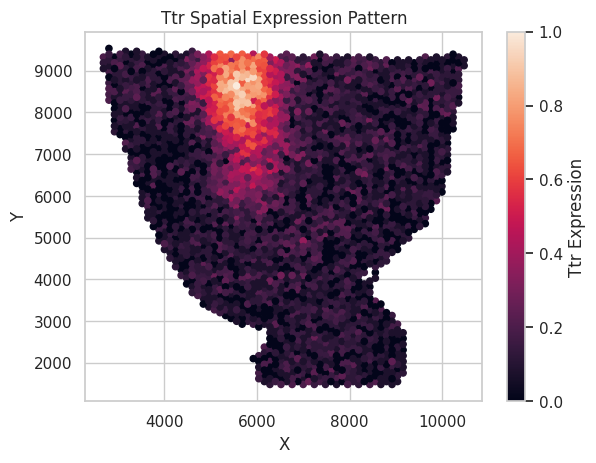

In [14]:
sns.set(style="whitegrid")
gene_name = de_idx[0]
scaler = MinMaxScaler()
plt.scatter(
        simu_data.obs["spatial1"],
        simu_data.obs["spatial2"],
        c=scaler.fit_transform(np.log1p(simu_data[:,gene_name].X)),
        alpha=1,
        s=20,
    )
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"{gene_name} Spatial Expression Pattern")
plt.colorbar(label=f"{gene_name} Expression",)
plt.show()

We also rescale the log count of 1 synthetic non-SVG here to the 0 to 1 scale and visualize it below.

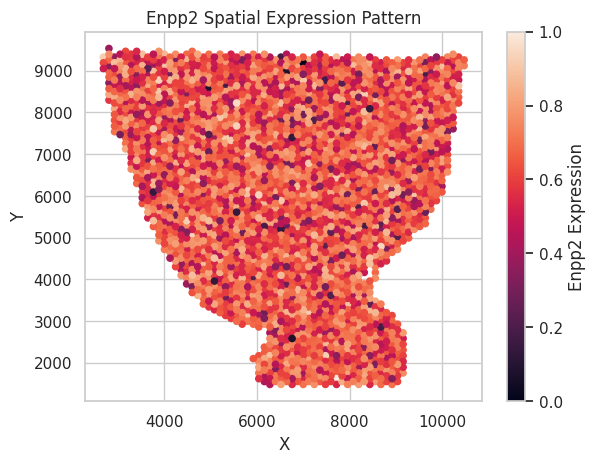

In [15]:
sns.set(style="whitegrid")
gene_name = no_de_idx[0]
scaler = MinMaxScaler()
plt.scatter(
        simu_data.obs["spatial1"],
        simu_data.obs["spatial2"],
        c=scaler.fit_transform(np.log1p(simu_data[:,gene_name].X)),
        alpha=1,
        s=20,
    )
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"{gene_name} Spatial Expression Pattern")
plt.colorbar(label=f"{gene_name} Expression",)
plt.show()

## SVG identification

Now, we use the simulated data to benchmark the performance of [SpatialDE](https://github.com/Teichlab/SpatialDE), a SVG identification method as an example.

In [16]:
qvals = pd.DataFrame(index=simu_data.var_names)
methods = ['SpatialDE']

In [17]:
result = SpatialDE.run(simu_data.obs[["spatial1","spatial2"]],example_newcount)
result.index = result["g"]
qvals["SpatialDE"] = result.loc[simu_data.var_names,"qval"]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Since we manually created non-SVG in the `extra_para()` step, now we can calculate the actual false discovery proportion(FDP) and power of the tests we conducted above with various target FDR threshold.

In [25]:
targetFDR = np.concatenate([np.arange(0.01,0.11,0.01),np.arange(0.2,0.6,0.1)])
fdp = pd.DataFrame(index=targetFDR,columns=methods)
power = pd.DataFrame(index=targetFDR,columns=methods)

for method in methods:
    curr_p = qvals[method]
    for threshold in targetFDR:
        discovery = curr_p[curr_p <= threshold]
        true_positive = discovery.index.intersection(de_idx).shape[0]

        if len(discovery) == 0:
            fdp.loc[threshold,method] = 0
        else:
            fdp.loc[threshold,method] = (len(discovery) - true_positive)/len(discovery)
        
        power.loc[threshold,method] = true_positive/de_idx.shape[0]

## Visualization

We visualize the Target FDR vs Actual FDP and Target FDR vs Power below.

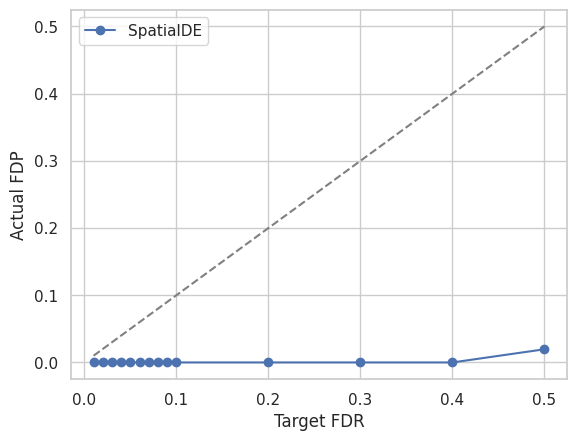

In [26]:
for method in methods:
    plt.plot(targetFDR,fdp[method],"o-",label=method)

plt.plot(targetFDR, targetFDR, '--', color='gray')
plt.xlabel('Target FDR')
plt.ylabel('Actual FDP')
plt.legend(loc="best")
plt.show()

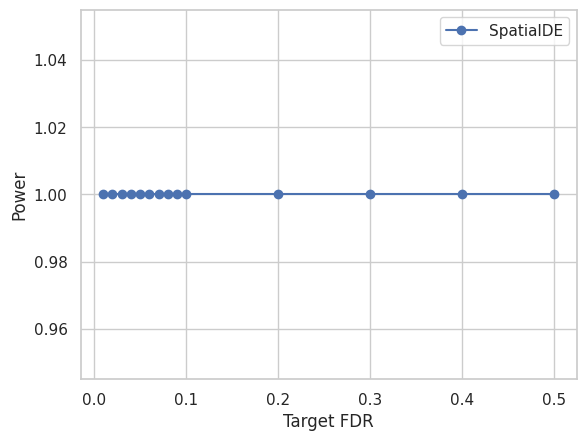

In [27]:
for method in methods:
    plt.plot(targetFDR,power[method],"o-",label=method)

plt.xlabel('Target FDR')
plt.ylabel('Power')
plt.legend(loc="best")
plt.show()